<a href="https://colab.research.google.com/github/bandsind/BlogApp/blob/main/Homework_Sindi_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Cats and Dogs

Applied Neural Networks <br/>
Dr. Leslie Kerby

Kaggle contains many useful datasets and data science competitions. It also has great tutorials and discussion boards. The data for this assignment comes from the [Kaggle Cats vs Dogs competition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview). Images such as these were once used for CAPTCHA (after digits and the alphabet proved too crackable). As stated in the overview, many years ago computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art (you should do better than this even without using CNNs). However, even back in 2014 state of the art machine learning could exceed 80% accuracy on this cat and dog dataset. This meant it was no longer useful for CAPTCHA. Currently, with the utilization of transfer learning this accuracy can exceed 95%.  

**Part 1** <br/>
Download the dataset. Go to [this link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) and set up your computer and Colab to easily download Kaggle datasets. Then download the `dogs-vs-cats-redux-kernels-edition` dataset. <br/>
*Note: You may set up the dataset another way (run jupyter locally etc) if you prefer*

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

100% 813M/814M [00:08<00:00, 45.0MB/s]
100% 814M/814M [00:08<00:00, 101MB/s] 


In [ ]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	kaggle.json  sample_data


In [ ]:
! unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
! mkdir train

In [ ]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	sample_data	       test.zip  train.zip
kaggle.json				sample_submission.csv  train


In [ ]:
! unzip train.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.5499.jpg  
  inflating: train/train/dog.55.jpg  
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519

**Part 2**<br/>
Preprocess the dataset (load it into one dataframe and create your `y` labels). <br/>
Print 5 sample images of dogs and cats (BEFORE they have been resized).

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


Using TensorFlow backend


<ipython-input-14-888fdbceff98>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
# You may find the following code hints useful

filenames = os.listdir("train/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
# Note: this randomizes the filenames

In [ ]:
df.head(5)

,filename,category
0,dog.7652.jpg,0
1,dog.1179.jpg,0
2,dog.3691.jpg,0
3,dog.3761.jpg,0
4,dog.11686.jpg,0


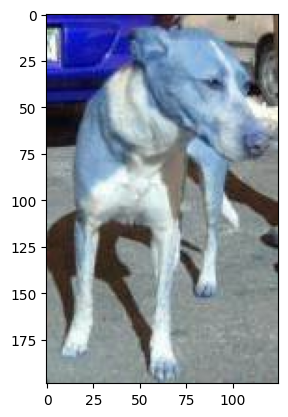

In [ ]:
import cv2
img = cv2.imread('train/train/'+df['filename'][0], cv2.IMREAD_COLOR)
plt.imshow(img)

You can then take `df` and create `y` from it and add each image to `X` (in order as found in df). Note that the images are all different sizes -- so we will need to resize and interpolate them before inputing them in Keras.

In [ ]:
# We haven't covered this yet so I'm giving you the code
import cv2

def resize_img(file_path):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (32,32))  # This tuple represents the final image size desired

X = np.ndarray((25000,32,32,3)) # 25000 images, 80x80 pixels, 3 channels (RGB)
for i,image_file in enumerate(df['filename']):
    X[i,:] = resize_img('train/train/'+image_file)


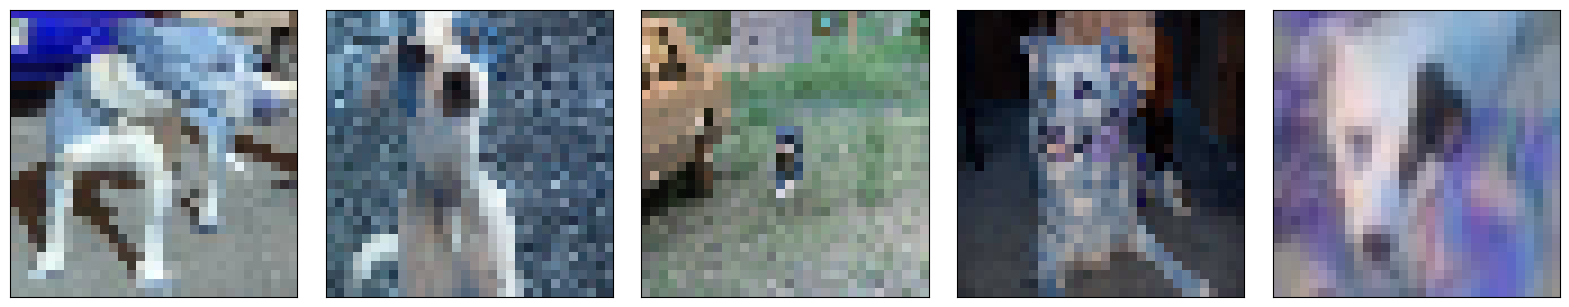

In [ ]:
# first few images from resized dataset
import matplotlib.pyplot as plt

def show_images(images, num=5):
    fig, axes = plt.subplots(1, num, figsize=(20, 20),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].astype(int))
    plt.show()

# Show the first 5 images
show_images(X, num=5)

In [ ]:
y = df['category']
y

0        0
1        0
2        0
3        0
4        0
        ..
24995    0
24996    0
24997    1
24998    0
24999    1
Name: category, Length: 25000, dtype: int64

**Part 3**<br/>
Now split the training data into training (15000 images), validation (5000 images), and testing (5000 images) datasets.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Normalize the images
X = X / 255.0

# Split dataset into Train and Test data (5,000 samples for testing)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, categories, test_size=5000, random_state=42)

# Split the Train dataset into Training and Validation sets (5,000 samples for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)


In [ ]:
X_train.shape

(15000, 32, 32, 3)

**Part 4**<br/>
Try different NN architectures and options. Use KerasTuner (or alternatively the sklearn tools RandomizedSearchCV or GridSearchCV) as part of this. Try at least one deep neural network with at least 50 hidden layers. Clearly state initialization, activation, architecture (including # layers and neurons, and pathways), any normalization/regularization used, and other relevant information for each model.

You are NOT expected to utilize transfer learning, data augmentation, or convolutional neural networks (these will be added in a future assignment).

Give converged validation and testing accuracy for each model trained (utilizing the EarlyStopping callback). Which one was the best? Display five misclassified images from your best model. Why do you think it was the best? Note: Your grade for this homework will depend on the quality of your best model.

In [ ]:
! pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
# Convert to numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
def build_model50(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32, 3)))

  # 50 hidden layers
  # not sure if the input and output layer count
  for i in range(50):

    model.add(keras.layers.Dense( hp.Int('units', min_value=32, max_value=512, step=32),activation='relu'))

  model.add(keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy',
                metrics=['accuracy'])


  return model

In [ ]:
tuner = kt.Hyperband(build_model50,
                     objective='val_accuracy',
                     max_epochs=5
                     )

In [ ]:
# Define an EarlyStopping callback
# This stops training once the model stops improving on the validation dataset.
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss at each epoch.
    patience=5           # Stop training after the validation loss doesn't improve for 5 consecutive epochs.
)


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[stop_early])


Trial 10 Complete [00h 01m 04s]
val_accuracy: 0.49959999322891235

Best val_accuracy So Far: 0.49959999322891235
Total elapsed time: 00h 40m 40s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Build model from best hyperparameters or use best model above
hyper_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Train best model from hyper_model (starts over)
hyper_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
469/469 [==============================] - 118s 226ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996
Epoch 2/10
469/469 [==============================] - 103s 220ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996
Epoch 3/10
469/469 [==============================] - 105s 224ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996
Epoch 4/10
469/469 [==============================] - 112s 239ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996
Epoch 5/10
469/469 [==============================] - 105s 224ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996
Epoch 6/10
469/469 [==============================] - 105s 224ms/step - loss: 7.6611 - accuracy: 0.5033 - val_loss: 7.7186 - val_accuracy: 0.4996


In [ ]:
# evaluate model
hyper_model.evaluate(X_test, y_test)

157/157 [==============================] - 6s 39ms/step - loss: 7.8606 - accuracy: 0.4904


[7.86055326461792, 0.4903999865055084]

157/157 [==============================] - 1s 7ms/step


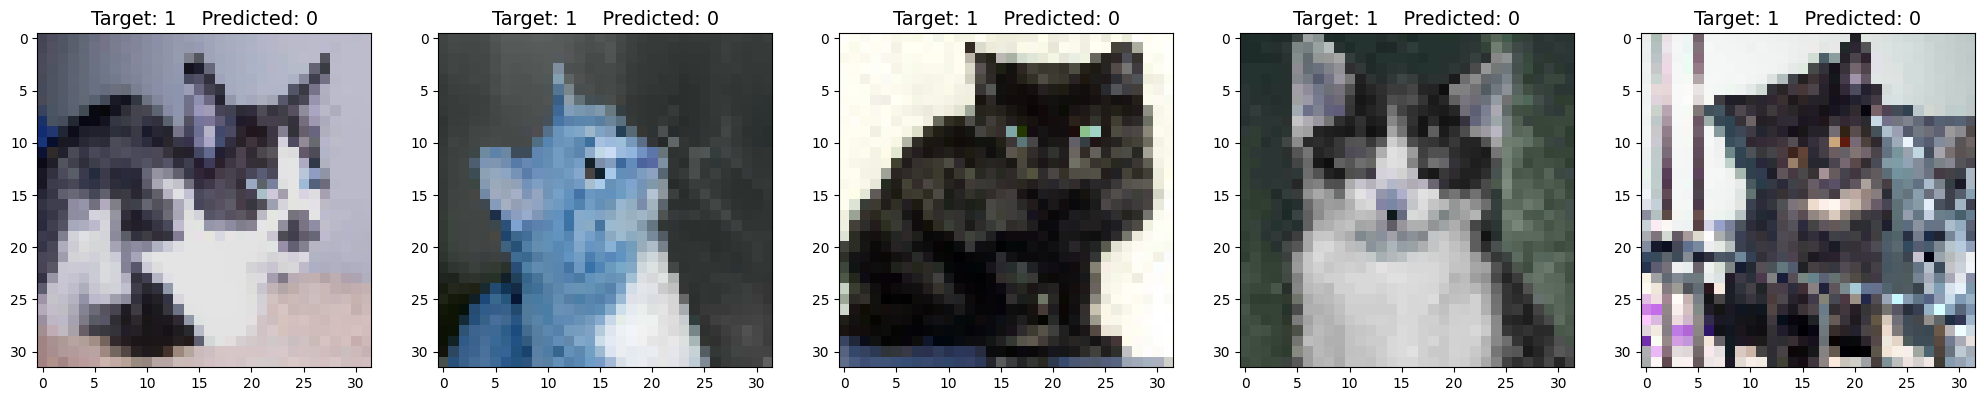

In [ ]:
# print misclassified images

predictions = np.argmax(hyper_model.predict(X_test), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes


plt.figure(figsize=(25,10))
for index in range(5):
    plt.subplot(1,5,index+1)
    plt.imshow(X_test[misclassifiedIndexes[index]].reshape(32,32, 3))
    plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

plt.show()


#Model2

In [ ]:
model2 = keras.models.Sequential()

# He initializer
initializer = keras.initializers.HeNormal()

# Input Layer
model2.add(keras.layers.Flatten(input_shape=(32, 32, 3)))

# Hidden layers
for _ in range(8):
    model2.add(keras.layers.Dense(500, activation="relu", kernel_initializer=initializer))
    model2.add(keras.layers.BatchNormalization())
    model2.add(keras.layers.Dropout(0.5))  # 50% dropout

# Output Layer
model2.add(keras.layers.Dense(1, activation="sigmoid", name="Output_Layer"))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model2.fit(X_train, y_train, epochs=10, batch_size=32,
                     validation_data=(X_val, y_val),
                     callbacks=[early_stopping])


Epoch 1/10
469/469 [==============================] - 46s 85ms/step - loss: 0.8335 - accuracy: 0.5149 - val_loss: 0.7515 - val_accuracy: 0.5366
Epoch 2/10
469/469 [==============================] - 38s 81ms/step - loss: 0.7405 - accuracy: 0.5251 - val_loss: 0.7359 - val_accuracy: 0.5802
Epoch 3/10
469/469 [==============================] - 42s 90ms/step - loss: 0.6971 - accuracy: 0.5657 - val_loss: 0.6703 - val_accuracy: 0.5902
Epoch 4/10
469/469 [==============================] - 38s 81ms/step - loss: 0.6740 - accuracy: 0.5913 - val_loss: 0.6709 - val_accuracy: 0.5808
Epoch 5/10
469/469 [==============================] - 38s 81ms/step - loss: 0.6681 - accuracy: 0.5985 - val_loss: 0.6653 - val_accuracy: 0.5794
Epoch 6/10
469/469 [==============================] - 37s 79ms/step - loss: 0.6596 - accuracy: 0.6116 - val_loss: 0.6524 - val_accuracy: 0.6198
Epoch 7/10
469/469 [==============================] - 39s 84ms/step - loss: 0.6585 - accuracy: 0.6091 - val_loss: 0.6645 - val_accuracy:

In [ ]:
# Evaluate the model on test data
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

157/157 [==============================] - 4s 26ms/step - loss: 0.6578 - accuracy: 0.6122
Test Loss: 0.6578170657157898
Test Accuracy: 0.6122000217437744


157/157 [==============================] - 3s 18ms/step


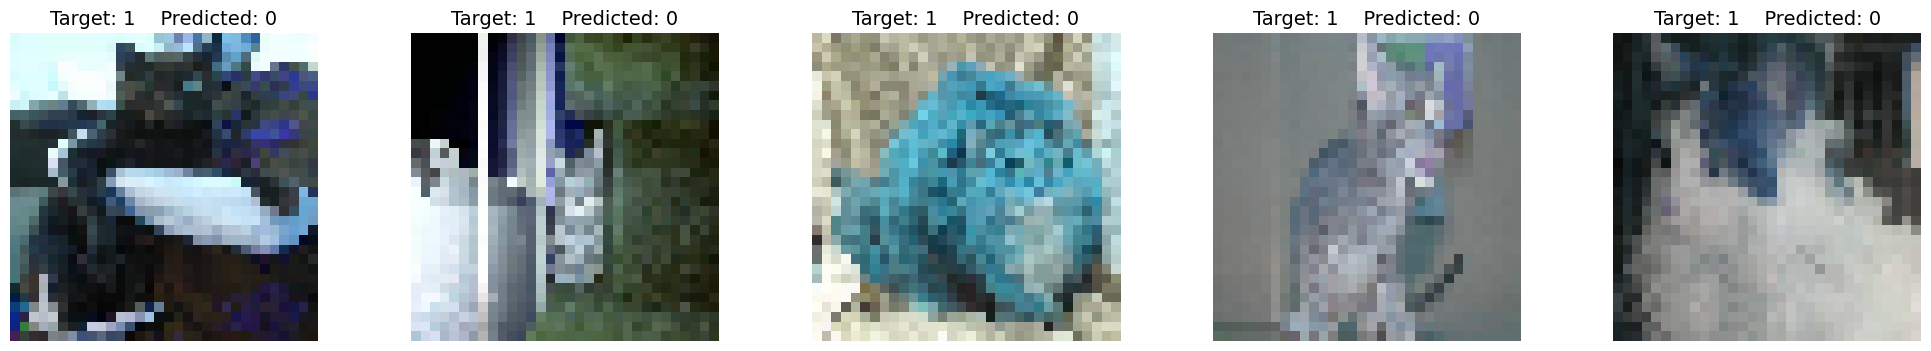

In [ ]:
# print misclassified images
predictions = np.argmax(model2.predict(X_test), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  # Update the reshape size to 32x32
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(32,32, 3), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

plt.show()


In [ ]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Flatten(input_shape=(32, 32, 3)))  # Corrected the input shape

# Batch normalization before activation can be beneficial
model3.add(keras.layers.BatchNormalization())

for i in range(100):
    model3.add(keras.layers.Dense(500, use_bias=False))  # Avoiding bias for batch normalization
    model3.add(keras.layers.BatchNormalization())
    model3.add(keras.layers.Activation("relu"))

    # Dropout for regularization. Typically 0.5 is used, but you can adjust this.
    model3.add(keras.layers.Dropout(0.5))

# Final layer
model3.add(keras.layers.Dense(1, activation="sigmoid", name="Output_Layer"))

model3.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])


In [ ]:
history = model3.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val),
                     callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/15
469/469 [==============================] - 264s 562ms/step - loss: 0.7003 - accuracy: 0.5021 - val_loss: 0.7006 - val_accuracy: 0.5014
Epoch 2/15
469/469 [==============================] - 253s 539ms/step - loss: 0.7013 - accuracy: 0.5049 - val_loss: 0.6934 - val_accuracy: 0.4996
Epoch 3/15
469/469 [==============================] - 245s 523ms/step - loss: 0.7002 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 4/15
469/469 [==============================] - 253s 539ms/step - loss: 0.7007 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 5/15
469/469 [==============================] - 253s 541ms/step - loss: 0.7004 - accuracy: 0.5100 - val_loss: 0.6938 - val_accuracy: 0.4996
Epoch 6/15
469/469 [==============================] - 253s 539ms/step - loss: 0.7004 - accuracy: 0.5007 - val_loss: 0.6940 - val_accuracy: 0.4996
Epoch 7/15
469/469 [==============================] - 246s 525ms/step - loss: 0.6998 - accuracy: 0.4968 - val_loss: 0.6933 -

In [ ]:
loss, accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


157/157 [==============================] - 15s 96ms/step - loss: 0.6930 - accuracy: 0.5096
Test Loss: 0.6930
Test Accuracy: 0.5096


157/157 [==============================] - 15s 96ms/step


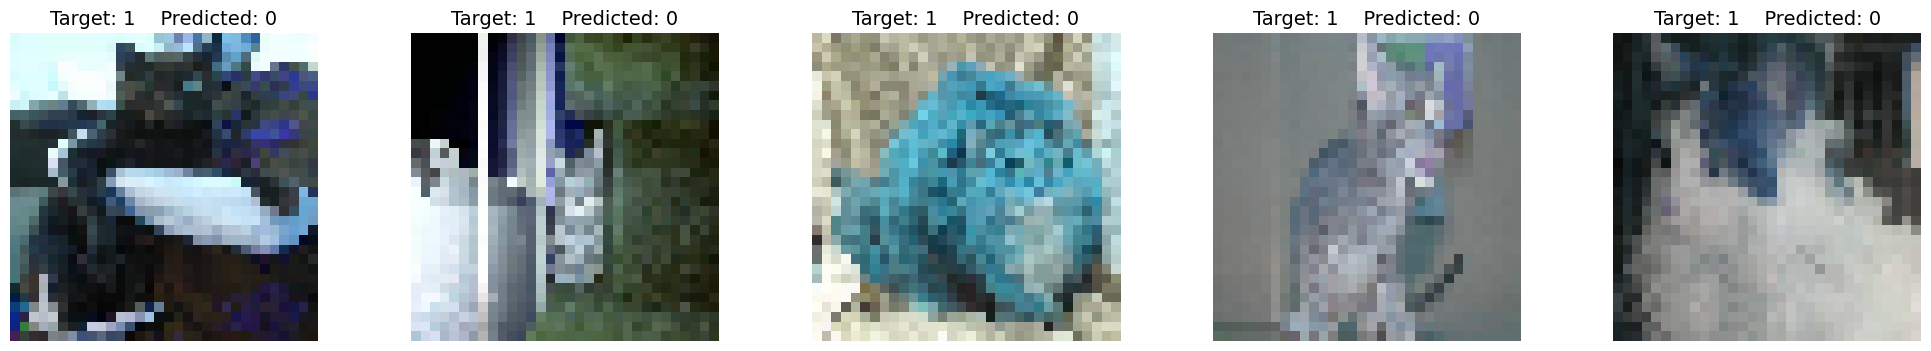

In [ ]:
# print misclassified images
predictions = np.argmax(model3.predict(X_test), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1, 5 , index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(32,32, 3), cmap='binary')  # Adjusted to 32x32
  plt.axis('off')
  plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

plt.show()


The Second model2 outperforms the other two models. The model2 achieved an accuracy of approximately 61.22% on the test set with a loss of 0.6578. The second model also exhibits a much lower test loss compared to the first model and third model.


**Graduate students only**<br/>
Utilize AutoKeras to create a model for classifying dogs and cats. What model does it build? Does it work better than your deep dense neural network? (I expect it will as AutoKeras will use CNNs)